In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objs as go
import matplotlib.pyplot as plt

from ostk.physics.units import Length
from ostk.physics.units import Angle
from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.time import Interval
from ostk.physics.time import DateTime
from ostk.physics import Environment
from ostk.physics.environment.objects.celestial_bodies import Earth

from ostk.astrodynamics import Trajectory
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory.orbit.models import Kepler
from ostk.astrodynamics.trajectory.orbit.models.kepler import COE

from utils import propagator, convertState

%load_ext autoreload
%autoreload 2

/srv/conda/envs/notebook/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for ostk::physics::time::DateTime already registered; second conversion method ignored.

/srv/conda/envs/notebook/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for ostk::math::obj::IntervalBase::Type already registered; second conversion method ignored.



Set up an OSTk reference environment and orbit.

In [2]:
environment = Environment.default()

a = Length.kilometers(7000.0)
e = 0.0001
i = Angle.degrees(35.0)
raan = Angle.degrees(40.0)
aop = Angle.degrees(45.0)
nu = Angle.degrees(50.0)

coe = COE(a, e, i, raan, aop, nu)

epoch = Instant.date_time(DateTime(2020, 1, 1, 0, 0, 0), Scale.UTC)
earth = environment.access_celestial_object_with_name("Earth")

Set up a time grid.

In [3]:
start_instant = Instant.date_time(DateTime(2020, 1, 1, 0, 0, 0), Scale.UTC)
end_instant   = Instant.date_time(DateTime(2020, 1, 1, 1, 0, 0), Scale.UTC)
interval = Interval.closed(start_instant, end_instant)
step = Duration.minutes(1.0)
instants = interval.generate_grid(step)

OSTk reference orbit.

In [4]:
keplerian_model = Kepler(coe, epoch, earth, Kepler.PerturbationType.No)
keplerian_orbit = Orbit(keplerian_model, earth)

Load our own models, filters and utilitary functions.

In [5]:
# Baseline Keplerian model
from models import keplerianDynamics, keplerianJacobian
# Perturbations model
from models import srpDynamics, srpJacobian

from measurement import g, generateMeasurementsNaive
from filters import EKF, UKF, PF, UPF

Propagate the orbit using our propagator to generate some true states.

In [6]:
X0 = np.array(convertState(keplerian_orbit.get_state_at(instants[0])))
dt = step.in_seconds()

X_kepler = np.zeros((len(instants), 6))
X_kepler[0,:] = X0
for t in range(1,len(instants)):
    X_kepler[t,:] = propagator(X_kepler[t-1,:], dt, keplerianDynamics)
    
X_srp = np.zeros((len(instants), 6))
X_srp[0,:] = X0
for t in range(1,len(instants)):
    X_srp[t,:] = propagator(X_srp[t-1,:], dt, srpDynamics)

/home/jovyan/utils.py:12: RuntimeWarning:

overflow encountered in multiply



Add process noise to true states, generate some noisy measurements.

In [7]:
# Covariance of process noise
Q = np.diag([1000, 1000, 1000, 10, 10, 10])

# Covariance of measurement noise
R = np.diag([1000, 1000, 1000, 10, 10, 10])

# Measurement matrices
C_kepler = np.array([np.eye(6) for instant in instants])

#Process noise
X_kepler_noisy = X_kepler + np.random.multivariate_normal(np.zeros(6),Q,len(instants))
X_srp_noisy = X_srp + np.random.multivariate_normal(np.zeros(6),Q,len(instants))

# Generate noisy measurements
Y_kepler = generateMeasurementsNaive(C=C_kepler, X=X_kepler_noisy, R=R)
Y_srp = generateMeasurementsNaive(C=C_kepler, X=X_srp_noisy, R=R)

In [8]:
# Initial mean and covariance
mu0 = X0
Sigma0 = np.diag([1000, 1000, 1000, 10, 10, 10])

## Extended Kalman Filter

In [9]:
mu, _ = EKF(X=X_kepler_noisy, Y=Y_kepler,
            mu0=mu0, Sigma0=Sigma0,
            Q=Q, R=R,
            fDynamics=keplerianDynamics,
            fMeas=g,
            JDynamics=keplerianJacobian,
            propagator=propagator,
            dt=dt
           )

[Text(0, 0.5, '$v_k^{ECI}$'), Text(0.5, 0, 'Time (sec)')]

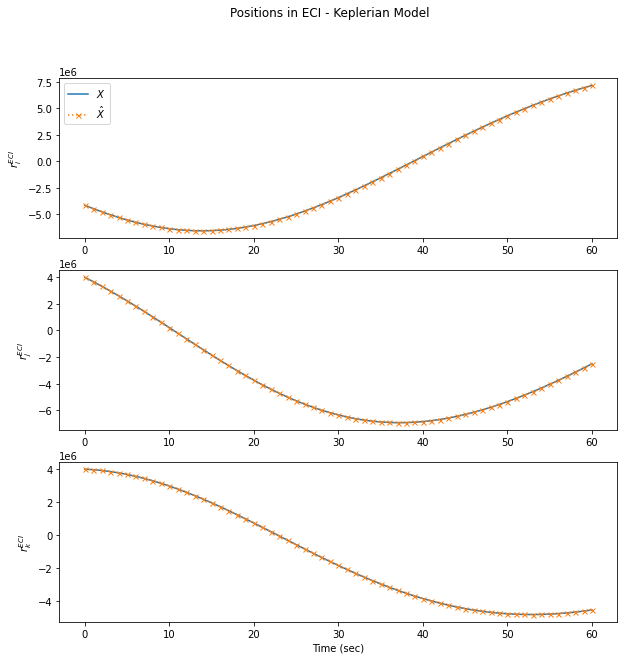

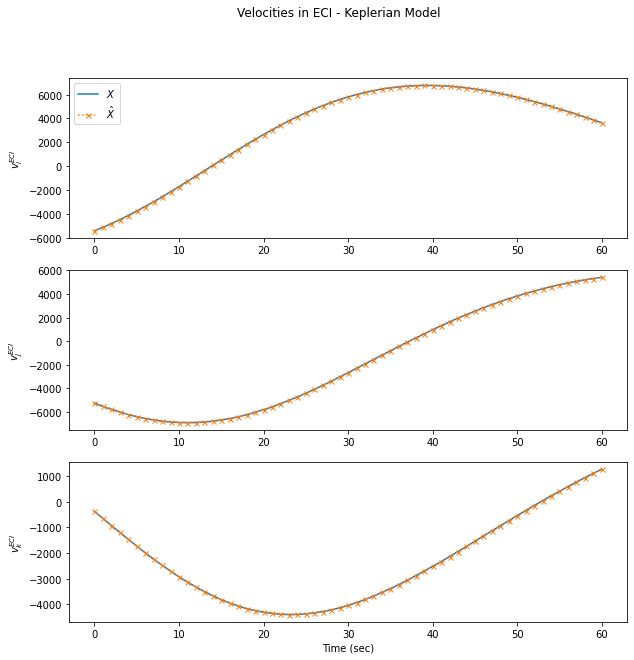

In [10]:
fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Positions in ECI - Keplerian Model')
axs[0].plot(X_kepler_noisy[:,0], label="$X$")
axs[0].plot(mu[:,0], ':x', ms=5, label="$\hat{X}$")
axs[0].set(ylabel="$r_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_kepler_noisy[:,1])
axs[1].plot(mu[:,1], ':x', ms=5)
axs[1].set(ylabel="$r_j^{ECI}$")
axs[2].plot(X_kepler_noisy[:,2])
axs[2].plot(mu[:,2], ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$r_k^{ECI}$")

fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Velocities in ECI - Keplerian Model')
axs[0].plot(X_kepler_noisy[:,3], label="$X$")
axs[0].plot(mu[:,3], ':x', ms=5, label="$\hat{X}$")
axs[0].set(ylabel="$v_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_kepler_noisy[:,4])
axs[1].plot(mu[:,4], ':x', ms=5)
axs[1].set(ylabel="$v_j^{ECI}$")
axs[2].plot(X_kepler_noisy[:,5])
axs[2].plot(mu[:,5], ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$v_k^{ECI}$")

[Text(0, 0.5, '$v_k^{ECI}$'), Text(0.5, 0, 'Time (sec)')]

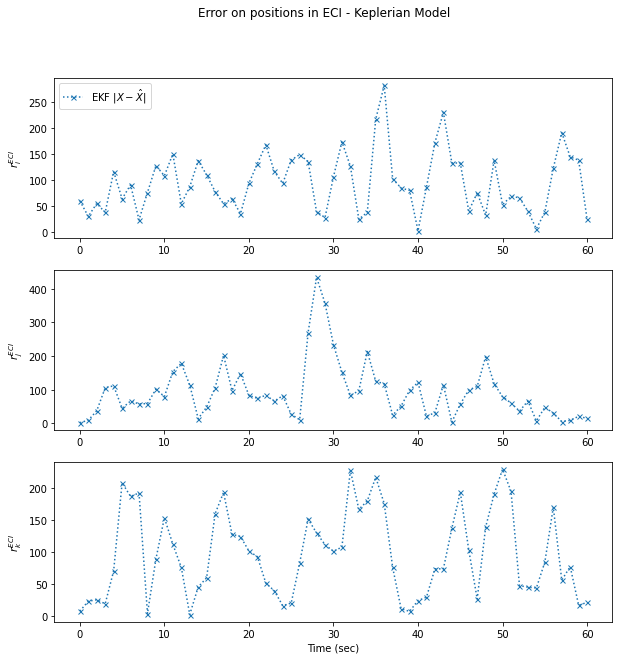

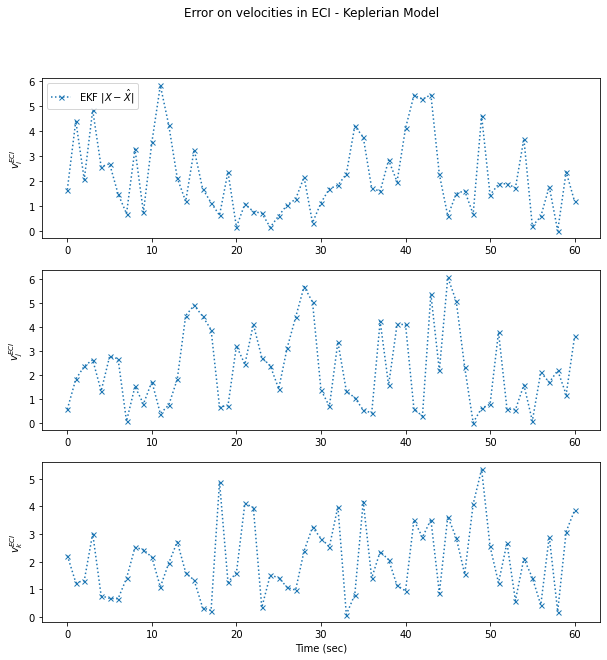

In [11]:
fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Error on positions in ECI - Keplerian Model')
axs[0].plot(abs(X_kepler_noisy[:,0]-mu[:,0]), ':x', ms=5, label="EKF $|X-\hat{X}|$")
axs[0].set(ylabel="$r_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(abs(X_kepler_noisy[:,1]-mu[:,1]), ':x', ms=5)
axs[1].set(ylabel="$r_j^{ECI}$")
axs[2].plot(abs(X_kepler_noisy[:,2]-mu[:,2]), ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$r_k^{ECI}$")

fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Error on velocities in ECI - Keplerian Model')
axs[0].plot(abs(X_kepler_noisy[:,3]-mu[:,3]), ':x', ms=5, label="EKF $|X-\hat{X}|$")
axs[0].set(ylabel="$v_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(abs(X_kepler_noisy[:,4]-mu[:,4]), ':x', ms=5)
axs[1].set(ylabel="$v_j^{ECI}$")
axs[2].plot(abs(X_kepler_noisy[:,5]-mu[:,5]), ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$v_k^{ECI}$")

Test the EKF on perturbation model: J2 + Drag + Moon + Sun + SRP.

In [12]:
mu_srp, _ = EKF(X_srp_noisy, Y_srp,
            mu0, Sigma0,
            Q=Q, R=R,
            fDynamics=srpDynamics,
            fMeas=g,
            JDynamics=srpJacobian,
            propagator=propagator,
            dt=dt
           )

/home/jovyan/utils.py:12: RuntimeWarning:

overflow encountered in multiply



## Unscented Kalman Filter

In [13]:
mu_UKF, _ = UKF(X=X_kepler_noisy, Y=Y_kepler,
            mu0=mu0, Sigma0=Sigma0,
            Q=Q, R=R,
            fDynamics=keplerianDynamics,
            fMeas=g,
            propagator=propagator,
            dt=dt
           )

mu_srp_UKF, _ = UKF(X=X_srp_noisy, Y=Y_srp, 
            mu0=mu0, Sigma0=Sigma0,
            Q=Q, R=R,
            fDynamics=srpDynamics,
            fMeas=g,
            propagator=propagator,
            dt=dt
           )

## Particle Filter

In [14]:
# Number of particles
N=100

mu_PF = PF(X=X_kepler_noisy, Y=Y_kepler,
        mu0=mu0, Sigma0=Sigma0,
        Q=Q, R=R, N=N,
        fDynamics=keplerianDynamics,
        fMeas=g,
        propagator=propagator,
        dt=dt
       )

mu_srp_PF = PF(X=X_srp_noisy, Y=Y_srp,
        mu0=mu0, Sigma0=Sigma0,
        Q=Q, R=R, N=N,
        fDynamics=srpDynamics,
        fMeas=g,
        propagator=propagator,
        dt=dt
       )

## Unscented Particle Filter

In [15]:
# Number of particles
N=10

mu_UPF = UPF(X=X_kepler_noisy, Y=Y_kepler,
        mu0=mu0, Sigma0=Sigma0,
        Q=Q, R=R, N=N,
        fDynamics=keplerianDynamics,
        fMeas=g,
        propagator=propagator,
        dt=dt
       )

mu_srp_UPF = UPF(X=X_srp_noisy, Y=Y_srp,
        mu0=mu0, Sigma0=Sigma0,
        Q=Q, R=R, N=N,
        fDynamics=srpDynamics,
        fMeas=g,
        propagator=propagator,
        dt=dt
       )

## Compare filters
Keplerian Model

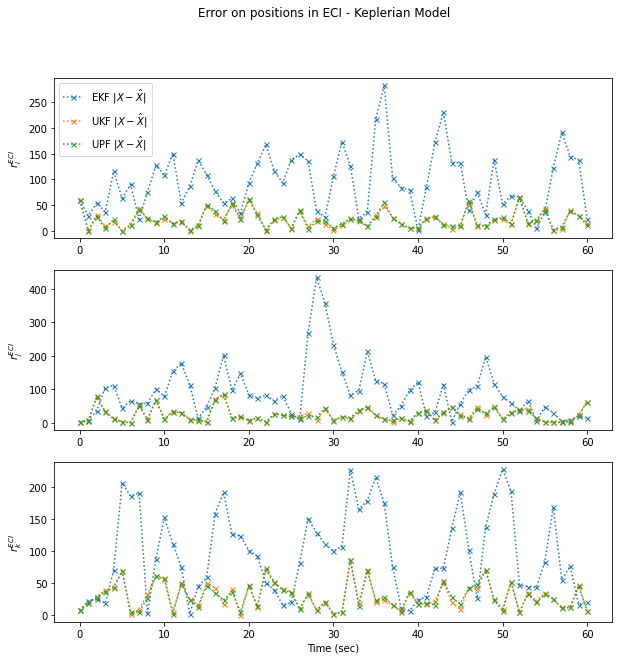

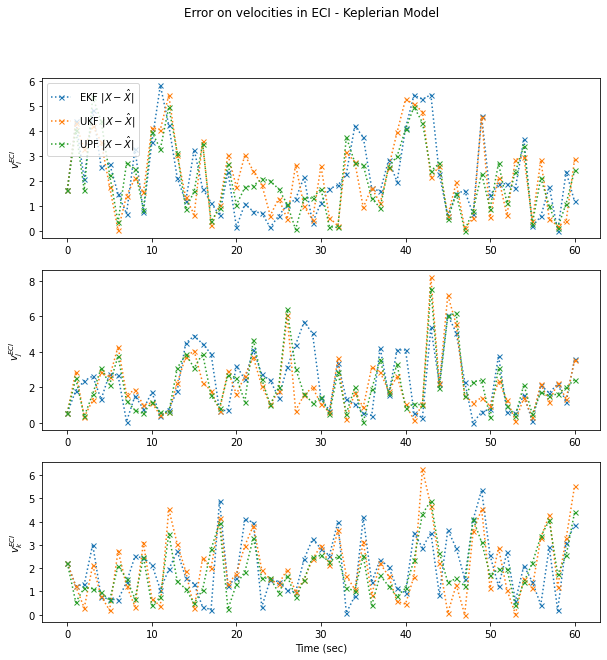

In [16]:
plot_PF = False
plot_UPF = True

fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Error on positions in ECI - Keplerian Model')
axs[0].plot(abs(X_kepler_noisy[:,0]-mu[:,0]), ':x', ms=5, label="EKF $|X-\hat{X}|$")
axs[0].plot(abs(X_kepler_noisy[:,0]-mu_UKF[:,0]), ':x', ms=5, label="UKF $|X-\hat{X}|$")
axs[0].set(ylabel="$r_i^{ECI}$")
axs[1].plot(abs(X_kepler_noisy[:,1]-mu[:,1]), ':x', ms=5)
axs[1].plot(abs(X_kepler_noisy[:,1]-mu_UKF[:,1]), ':x', ms=5)
axs[1].set(ylabel="$r_j^{ECI}$")
axs[2].plot(abs(X_kepler_noisy[:,2]-mu[:,2]), ':x', ms=5)
axs[2].plot(abs(X_kepler_noisy[:,2]-mu_UKF[:,2]), ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$r_k^{ECI}$")
if plot_PF:
    axs[0].plot(abs(X_kepler_noisy[:,0]-mu_PF[:,0]), ':x', ms=5, label="  PF $|X-\hat{X}|$")
    axs[1].plot(abs(X_kepler_noisy[:,1]-mu_PF[:,1]), ':x', ms=5)
    axs[2].plot(abs(X_kepler_noisy[:,2]-mu_PF[:,2]), ':x', ms=5)
if plot_UPF:
    axs[0].plot(abs(X_kepler_noisy[:,0]-mu_UPF[:,0]), ':x', ms=5, label="UPF $|X-\hat{X}|$")
    axs[1].plot(abs(X_kepler_noisy[:,1]-mu_UPF[:,1]), ':x', ms=5)
    axs[2].plot(abs(X_kepler_noisy[:,2]-mu_UPF[:,2]), ':x', ms=5)
axs[0].legend(loc="upper left")
    
fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Error on velocities in ECI - Keplerian Model')
axs[0].plot(abs(X_kepler_noisy[:,3]-mu[:,3]), ':x', ms=5, label="EKF $|X-\hat{X}|$")
axs[0].plot(abs(X_kepler_noisy[:,3]-mu_UKF[:,3]), ':x', ms=5, label="UKF $|X-\hat{X}|$")
axs[0].set(ylabel="$v_i^{ECI}$")
axs[1].plot(abs(X_kepler_noisy[:,4]-mu[:,4]), ':x', ms=5)
axs[1].plot(abs(X_kepler_noisy[:,4]-mu_UKF[:,4]), ':x', ms=5)
axs[1].set(ylabel="$v_j^{ECI}$")
axs[2].plot(abs(X_kepler_noisy[:,5]-mu[:,5]), ':x', ms=5)
axs[2].plot(abs(X_kepler_noisy[:,5]-mu_UKF[:,5]), ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$v_k^{ECI}$")
if plot_PF:
    axs[0].plot(abs(X_kepler_noisy[:,3]-mu_PF[:,3]), ':x', ms=5, label="  PF $|X-\hat{X}|$")
    axs[1].plot(abs(X_kepler_noisy[:,4]-mu_PF[:,4]), ':x', ms=5)
    axs[2].plot(abs(X_kepler_noisy[:,5]-mu_PF[:,5]), ':x', ms=5)
if plot_UPF:
    axs[0].plot(abs(X_kepler_noisy[:,3]-mu_UPF[:,3]), ':x', ms=5, label="UPF $|X-\hat{X}|$")
    axs[1].plot(abs(X_kepler_noisy[:,4]-mu_UPF[:,4]), ':x', ms=5)
    axs[2].plot(abs(X_kepler_noisy[:,5]-mu_UPF[:,5]), ':x', ms=5)
axs[0].legend(loc="upper left")

Perturbations Model: J2 + Drag + Moon + Sun + SRP

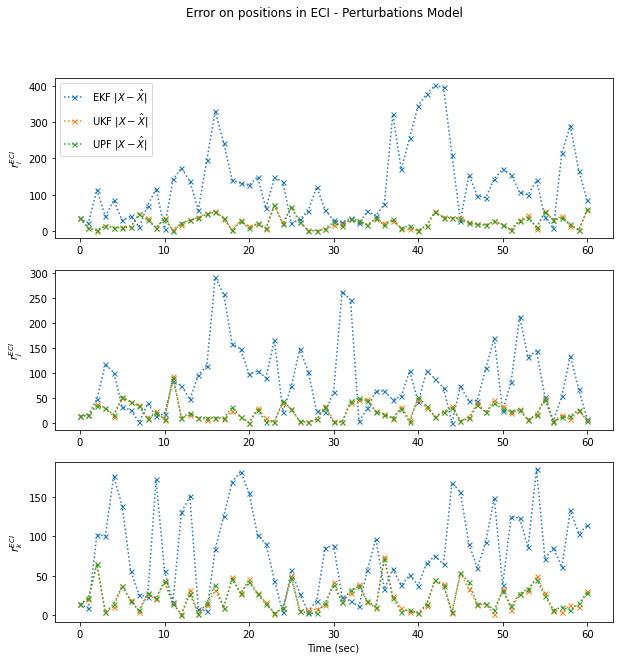

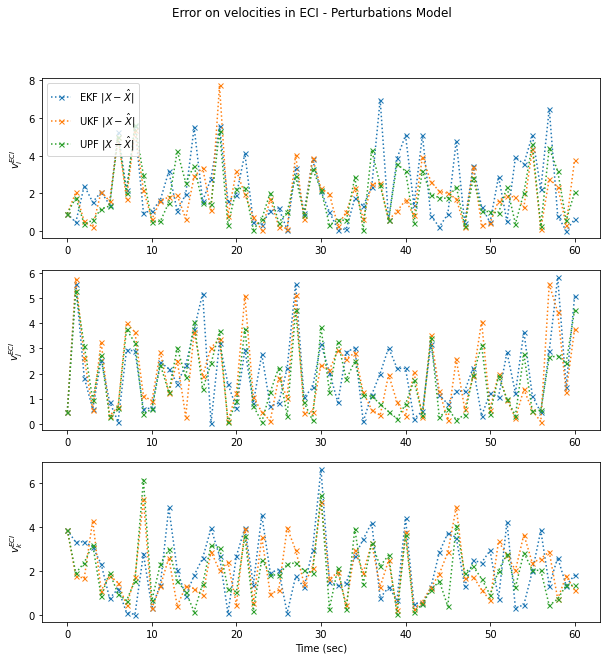

In [17]:
fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Error on positions in ECI - Perturbations Model')
axs[0].plot(abs(X_srp_noisy[:,0]-mu_srp[:,0]), ':x', ms=5, label="EKF $|X-\hat{X}|$")
axs[0].plot(abs(X_srp_noisy[:,0]-mu_srp_UKF[:,0]), ':x', ms=5, label="UKF $|X-\hat{X}|$")
axs[0].set(ylabel="$r_i^{ECI}$")
axs[1].plot(abs(X_srp_noisy[:,1]-mu_srp[:,1]), ':x', ms=5)
axs[1].plot(abs(X_srp_noisy[:,1]-mu_srp_UKF[:,1]), ':x', ms=5)
axs[1].set(ylabel="$r_j^{ECI}$")
axs[2].plot(abs(X_srp_noisy[:,2]-mu_srp[:,2]), ':x', ms=5)
axs[2].plot(abs(X_srp_noisy[:,2]-mu_srp_UKF[:,2]), ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$r_k^{ECI}$")
if plot_PF:
    axs[0].plot(abs(X_srp_noisy[:,0]-mu_srp_PF[:,0]), ':x', ms=5, label="  PF $|X-\hat{X}|$")
    axs[1].plot(abs(X_srp_noisy[:,1]-mu_srp_PF[:,1]), ':x', ms=5)
    axs[2].plot(abs(X_srp_noisy[:,2]-mu_srp_PF[:,2]), ':x', ms=5)
if plot_UPF:
    axs[0].plot(abs(X_srp_noisy[:,0]-mu_srp_UPF[:,0]), ':x', ms=5, label="UPF $|X-\hat{X}|$")
    axs[1].plot(abs(X_srp_noisy[:,1]-mu_srp_UPF[:,1]), ':x', ms=5)
    axs[2].plot(abs(X_srp_noisy[:,2]-mu_srp_UPF[:,2]), ':x', ms=5)
axs[0].legend(loc="upper left")
    
fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Error on velocities in ECI - Perturbations Model')
axs[0].plot(abs(X_srp_noisy[:,3]-mu_srp[:,3]), ':x', ms=5, label="EKF $|X-\hat{X}|$")
axs[0].plot(abs(X_srp_noisy[:,3]-mu_srp_UKF[:,3]), ':x', ms=5, label="UKF $|X-\hat{X}|$")
axs[0].set(ylabel="$v_i^{ECI}$")
axs[1].plot(abs(X_srp_noisy[:,4]-mu_srp[:,4]), ':x', ms=5)
axs[1].plot(abs(X_srp_noisy[:,4]-mu_srp_UKF[:,4]), ':x', ms=5)
axs[1].set(ylabel="$v_j^{ECI}$")
axs[2].plot(abs(X_srp_noisy[:,5]-mu_srp[:,5]), ':x', ms=5)
axs[2].plot(abs(X_srp_noisy[:,5]-mu_srp_UKF[:,5]), ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$v_k^{ECI}$")
if plot_PF:
    axs[0].plot(abs(X_srp_noisy[:,3]-mu_srp_PF[:,3]), ':x', ms=5, label="  PF $|X-\hat{X}|$")
    axs[1].plot(abs(X_srp_noisy[:,4]-mu_srp_PF[:,4]), ':x', ms=5)
    axs[2].plot(abs(X_srp_noisy[:,5]-mu_srp_PF[:,5]), ':x', ms=5)
if plot_UPF:
    axs[0].plot(abs(X_srp_noisy[:,3]-mu_srp_UPF[:,3]), ':x', ms=5, label="UPF $|X-\hat{X}|$")
    axs[1].plot(abs(X_srp_noisy[:,4]-mu_srp_UPF[:,4]), ':x', ms=5)
    axs[2].plot(abs(X_srp_noisy[:,5]-mu_srp_UPF[:,5]), ':x', ms=5)
axs[0].legend(loc="upper left")